In [1]:
import random
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [2]:
EPS = 1e-6

In [3]:
class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
def zero_pad(X, pad):
    assert len(X.shape) == 4, "X must be with shape [batch, h, w, c]"
    
    X_pad = F.pad(X, (
        *(0, 0), 
        *(pad, pad),
        *(pad, pad),
        *(0, 0)
    ), value=0)

    return X_pad



class Conv2D:
    def __init__(self, prev_channels, next_channels, kernel=3, stride=1, pad=0):
        self._cache = None
        self.stride = stride
        self.pad = pad
        
        self.kernel = torch.randn(kernel, kernel, prev_channels, next_channels)
        self.b = torch.zeros(next_channels)
    
    def forward(self, A_prev):
        # (m, n_H_prev, n_W_prev, n_C_prev) -> (m, n_H, n_W, n_C) by (k, k, n_C_prev, n_C)

        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        k, k, n_C_prev, n_C = self.kernel.shape

        n_H = (n_H_prev + 2*self.pad - k) // self.stride + 1
        n_W = (n_W_prev + 2*self.pad - k) // self.stride + 1

        output = torch.zeros((m, n_H, n_W, n_C))
        A_prev_pad = zero_pad(A_prev, pad=self.pad)
        
        for i in range(m):
            a_prev_pad = A_prev_pad[i]

            for h in range(n_H):
                h_start = h * self.stride 
                h_end = h_start + k

                for w in range(n_W):
                    w_start = w * self.stride
                    w_end = w_start + k

                    for c in range(n_C):
                        a_slice = a_prev_pad[h_start:h_end, w_start:w_end, :]
                        current_kernel = self.kernel[:, :, :, c]
                        current_bias = self.b[c]
                       
                        output[i, h, w, c] = torch.sum(a_slice * current_kernel) + current_bias
        
        self.cache = A_prev
        return output
    
    def backward(self, dZ):
        A_prev = self.cache
        
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        k, k, n_C_prev, n_C = self.kernel.shape
        m, n_H, n_W, n_C = dZ.shape 
        
        dA_prev = torch.zeros((m, n_H_prev, n_W_prev, n_C_prev))
        dW = torch.zeros((k, k, n_C_prev, n_C))
        db = torch.zeros(n_C)
        
        A_prev_pad = zero_pad(A_prev, self.pad)
        dA_prev_pad = zero_pad(dA_prev, self.pad)
        
        for i in range(m):
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]
            
            for h in range(n_H):
                h_start = h * self.stride 
                h_end = h_start + k
                
                for w in range(n_W):
                    w_start = w * self.stride
                    w_end = w_start + k
                    
                    for c in range(n_C):
                        a_slice = a_prev_pad[h_start:h_end, w_start:w_end, :]
                        
                        da_prev_pad[h_start:h_end, w_start:w_end, :] += self.kernel[:, :, :, c] * dZ[i, h, w, c]
                        dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                        db[c] += dZ[i, h, w, c]
            if self.pad == 0:
                dA_prev[i, :, :, :] = da_prev_pad[:, :, :]
            else:
                dA_prev[i, :, :, :] = da_prev_pad[self.pad:-self.pad, self.pad:-self.pad, :]
            
        assert dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev)
            
        return dA_prev, dW, db

In [5]:
def rotate180(matrix):
    assert len(matrix.shape) == 4
    matrix180 = torch.flip(matrix, [2, 1])
    return matrix180


def upsample(X, stride=2, pad=0):
    assert len(X.shape) == 4, "X should be with shape [batch, h, w, c]"
    
    m, n_H_prev, n_W_prev, c = X.shape
    
    n_H = stride * (n_H_prev - 1) + 1
    n_W = stride * (n_W_prev - 1) + 1
    
    upsampled = torch.zeros((m, n_H, n_W, c))
    
    for h in range(n_H_prev):
        for w in range(n_W_prev):
            upsampled[:, h*stride, w*stride, :] = X[:, h, w, :]
    
    upsampled_pad = zero_pad(upsampled, pad=pad)
    
    return upsampled_pad


def downsample(X, stride, pad): 
    assert stride >= 0
    assert pad >= 0
    
    if pad == 0:
        res = X[:, ::stride, ::stride, :]
    else:
        res = X[:, pad:-pad:stride, pad:-pad:stride, :]
    
    return res


class Conv2DTranspose:
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=0):
        self.cache = None 
        self.padding = padding
        self.stride = stride
        
        self.conv = Conv2D(in_channels, out_channels, kernel=kernel_size, stride=1, pad=0)
        
    def forward(self, A_prev):
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape 
        k, k, n_C_prev, n_C = self.kernel.shape
        
        n_H = self.stride * (n_H_prev - 1) + k - 2 * self.padding
        n_W = self.stride * (n_W_prev - 1) + k - 2 * self.padding
        
        implicit_padding = k - self.padding - 1
        assert implicit_padding >= 0
        
        A_prev_upsampled = upsample(A_prev, stride=self.stride, pad=implicit_padding)
        out = self.conv.forward(A_prev_upsampled)
        
        assert out.shape == (m, n_H, n_W, n_C)
        
        self.cache = A_prev
        return out
    
    def backward(self, dZ):
        A_prev = self.cache 
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        k, k, n_C_prev, n_C = self.kernel.shape
        m, n_H, n_W, n_C = dZ.shape
        
        dA_upsampled, dW, db = self.conv.backward(dZ)
        
        implicit_padding = k - self.padding - 1
        dA = downsample(dA_upsampled, self.stride, pad=implicit_padding)
        
        return dA, dW, db
    
    @property 
    def kernel(self):
        return self.conv.kernel
    
    @kernel.setter
    def kernel(self, weights):
        self.conv.kernel = weights
        
    @property 
    def b(self):
        return self.conv.b
    
    @kernel.setter
    def b(self, biases):
        self.conv.b = biases

In [6]:
class Conv2DTransposeV2:
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, output_padding=1):
        self.cache = None
        self.stride = stride
        self.pad = padding 
        self.output_pad = output_padding
        self.kernel = torch.rand(kernel_size, kernel_size, in_channels, out_channels)
        self.b = torch.zeros(out_channels)
        
        self.kernel.requires_grad = True 
        self.b.requires_grad = True
        
    def forward(self, A_prev):
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        k, k, n_C_prev, n_C = self.kernel.shape
        
        n_H = self.stride * (n_H_prev - 1) + k - 2 * self.pad + self.output_pad
        n_W = self.stride * (n_W_prev - 1) + k - 2 * self.pad + self.output_pad
        
        output_pad = torch.zeros((m, n_H - self.output_pad + 2*self.pad, n_W - self.output_pad + 2*self.pad, n_C))
        
        for c_out in range(n_C): # by kernels/out_channels
            
            for h in range(n_H_prev):
                h_start = h * self.stride 
                h_end = h_start + k

                for w in range(n_W_prev):
                    w_start = w * self.stride
                    w_end = w_start + k 
                    
                    output_pad[:, h_start:h_end, w_start:w_end, c_out] += (A_prev[:, h, w, :] * self.kernel[:, :, :, c_out]).sum(axis=-1)
            
            output_pad[:, :, :, c_out] += self.b[c_out]
                
        output = output_pad[:, self.output_pad:, self.output_pad:, :]
        
        self.cache = (A_prev, output_pad)
        
        return output    
    
    def backward(self, dZ):
        A_prev, output_pad = self.cache 
        
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        k, k, n_C_prev, n_C = self.kernel.shape
        dZ_pad = np.pad(dZ, (
            (0, 0), 
            (self.output_pad, 0), 
            (self.output_pad, 0), 
            (0, 0)
        ), mode="constant", constant_values=(0, 0))
        print(dZ_pad.shape)
        # dW = convolve dZ_pad by A
        # db = sum(dZ)
        # dA_prev = convolve dZ_pad by kernel
        

**I didn't have enough time to implement the backward propagation for Conv2DTransposeV2, but I suggest taking a look at my draft with the derivation of gradient formulas for Conv2D and Conv2DTranspose at the end of this notebook.**

# Tests

## Test zero_pad

In [7]:
m = 30
h = 40
w = 40
c = 3
pad = 1

X_batch = torch.rand(m, h, w, c)
shape1 = X_batch.shape
X_pad = zero_pad(X_batch, pad=pad)
shape2 = X_pad.shape

print(shape1, shape2)
print(
    shape1[0] == shape2[0], 
    shape1[1]+pad*2 == shape2[1], 
    shape1[2]+2*pad == shape2[2], 
    shape1[3] == shape2[3]
)

torch.Size([30, 40, 40, 3]) torch.Size([30, 42, 42, 3])
True True True True


In [8]:
# b = np.random.rand(1, 1, 1)
b = 1
b = np.array(b)
b.shape == (1, 1, 1) or b.shape == ()

True

## Conv2D forward 

In [9]:
m = 16
n_H_prev = 33
n_W_prev = 33
n_C_prev = 8
n_C = 16

kernel = 3
pad = 1
stride = 1


X_batch = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
conv2d = Conv2D(n_C_prev, n_C, kernel=kernel, pad=pad, stride=stride)
out = conv2d.forward(X_batch)
print(out.shape)

del m 
del n_H_prev
del n_W_prev
del n_C_prev
del n_C
del kernel
del pad 
del stride

torch.Size([16, 33, 33, 16])


## Comparsion Conv2D forward with Torch

In [10]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def compare_conv(
            m, 
            n_H_prev, 
            n_W_prev, 
            n_C_prev, 
            n_C, 
            kernel,
            pad, 
            stride
        ):
    
    input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
    
    # my realization 
    my_conv = Conv2D(n_C_prev, n_C, kernel=kernel, stride=stride, pad=pad)
    my_out = my_conv.forward(input_data)
    
    # torch_realizatoin 
    torch_input = torch.permute(input_data, [0, 3, 1, 2]) # (m, n_C_prev, n_H_prev, n_W_prev)
    torch_weights = torch.permute(my_conv.kernel.clone(), [3, 2, 0, 1]) # [k, k, channels, filters] -> [filters, channels, k, k]
    torch_biases = my_conv.b.clone()
    torch_out_ = F.conv2d(torch_input, torch_weights, bias=torch_biases, padding=pad, stride=stride)
    
    torch_out = torch.permute(torch_out_, [0, 2, 3, 1]).numpy() 
    
    mse = np.power(my_out - torch_out, 2).mean()
    
    return mse

res = compare_conv(
    m = 16,
    n_H_prev = 32,
    n_W_prev = 32,
    n_C_prev = 8,
    n_C = 16,

    kernel = 3,
    pad = 1,
    stride = 1,
)
print(res)

if res < EPS:
    print(Color.GREEN + Color.BOLD + "OK")
else:
    print(Color.RED + Color.BOLD + "Error")
    
del res

tensor(6.4674e-13)
OK


## Conv2d backward

In [11]:
kernel = 3
pad = 1
stride = 1

m = 16
n_H_prev = 32
n_W_prev = 32
n_C_prev = 8
n_C = 16

n_H = (n_H_prev + 2*pad - kernel) // stride + 1
n_W = (n_W_prev + 2*pad - kernel) // stride + 1

input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
dZ = torch.rand(m, n_H, n_W, n_C)

my_conv = Conv2D(n_C_prev, n_C, kernel=kernel, stride=stride, pad=pad)
conv_out = my_conv.forward(input_data)

dA, dW, db = my_conv.backward(dZ)
print(dA.shape)
print(dW.shape)
print(db.shape)


del kernel
del pad
del stride

del m
del n_H_prev
del n_W_prev
del n_C_prev
del n_C

torch.Size([16, 32, 32, 8])
torch.Size([3, 3, 8, 16])
torch.Size([16])


## Comparsion Conv2D backward with Torch

In [12]:
def compare_conv_back(
            kernel,
            pad,
            stride,
            m,
            n_H_prev,
            n_W_prev,
            n_C_prev,
            n_C,
        ):
    n_H = (n_H_prev + 2*pad - kernel) // stride + 1
    n_W = (n_W_prev + 2*pad - kernel) // stride + 1
    
    input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
    dZ = torch.rand(m, n_H, n_W, n_C)
    
    weights = torch.rand(kernel, kernel, n_C_prev, n_C)
    biases = torch.zeros(n_C)
    
    # my realization 
    my_conv = Conv2D(n_C_prev, n_C, kernel=kernel, stride=stride, pad=pad)
    my_conv.kernel = weights.clone()
    my_conv.b = biases.clone()
    
    conv_out = my_conv.forward(input_data)

    dA, dW, db = my_conv.backward(dZ)
    
    # torch realization
    torch_input = torch.permute(input_data, [0, 3, 1, 2])
    torch_dZ = torch.permute(dZ, [0, 3, 1, 2])
    torch_weights = torch.permute(weights.detach().clone(), [3, 2, 0, 1])
    torch_biases = biases.detach().clone()
    
    torch_input.requires_grad = True
    torch_weights.requires_grad = True
    torch_biases.requires_grad = True
    torch_dZ.requires_grad = False
    
    torch_out = F.conv2d(torch_input, torch_weights, bias=torch_biases, padding=pad, stride=stride)
    
    torch_out.backward(gradient=torch_dZ)
    
    dA_torch = torch_input.grad
    dW_torch = torch_weights.grad
    db_torch = torch_biases.grad
    
    dA_torch = torch.permute(dA_torch, [0, 2, 3, 1]) # [m, channels, h, w] -> [m, h, w, channels]
    dW_torch = torch.permute(dW_torch, [2, 3, 1, 0]) # [filters, channels, k, k] -> [k, k, channels, filters] 
    db_torch = db_torch
    assert dA.shape == dA_torch.shape and dW.shape == dW_torch.shape and db.shape == db_torch.shape
    
    mse = lambda a, b: np.power(a - b, 2).mean()
    mse_dA = mse(dA, dA_torch)
    mse_dW = mse(dW, dW_torch)
    mse_db = mse(db, db_torch)
    
    return mse_dA, mse_dW, mse_db

In [13]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

mse_dA, mse_dW, mse_db = compare_conv_back(
    kernel = 3,
    pad = 1,
    stride = 1,

    m = 1,
    n_H_prev = 32,
    n_W_prev = 32,
    n_C_prev = 8,
    n_C = 16
)

print(mse_dA)
print(mse_dW)
print(mse_db)

if mse_dA < EPS and mse_dW < EPS and mse_db < EPS:
    print(Color.GREEN + Color.BOLD + "OK")
else:
    print(Color.RED + Color.BOLD + "Error")

tensor(4.5672e-11)
tensor(7.4581e-09)
tensor(4.0396e-08)
OK


## Conv2D Transpose

In [14]:
arr = torch.tensor([
    [2, 5],
    [4, 13]
])
kernel = torch.tensor([
    [3, 1, 2],
    [2, 0, 0],
    [5, 4, 7]
])

batch = arr[None, ..., None]
weights = kernel[..., None, None]

convt = Conv2DTranspose(1, 1, kernel_size=3, stride=2, padding=1)
convt.kernel = weights

out = convt.forward(batch)
print(out.squeeze())


del convt
del out 
del weights 
del batch
del kernel 
del arr

 # [  0   4   0]
 # [ 18 127  57]
 # [  0   8   0]

tensor([[  0.,   4.,   0.],
        [ 18., 127.,  57.],
        [  0.,   8.,   0.]])


## Comparsion Conv2DTranspose forward with Torch

In [15]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)


def compare_convt(
            m,
            n_H_prev,
            n_W_prev,
            n_C_prev,
            n_C,
            kernel,
            pad,
            stride
        ):
    input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
    weights = torch.rand(kernel, kernel, n_C_prev, n_C)
    biases = torch.zeros(n_C)
    
    # my realizatoin 
    my_convt = Conv2DTranspose(n_C_prev, n_C, kernel_size=kernel, stride=stride, padding=pad)
    my_convt.kernel = rotate180(weights).clone()
    my_convt.b = biases.clone()
    
    my_out = my_convt.forward(input_data)
    
    # torch realization 
    torch_input = torch.permute(input_data, [0, 3, 1, 2]) # (m, n_C_prev, n_H_prev, n_W_prev)
    torch_weights = torch.permute(weights.clone(), [2, 3, 0, 1]) # [k, k, channels, filters] -> [channels, filters, k, k]
    torch_biases = biases.clone()
    torch_out_ = F.conv_transpose2d(torch_input, torch_weights, bias=torch_biases, padding=pad, stride=stride)
    
    torch_out = torch.permute(torch_out_, [0, 2, 3, 1]).numpy() 
    
    mse = torch.pow(my_out - torch_out, 2).mean()
    return mse


np.random.seed(1)
random.seed(1)

res = compare_convt(
    m = 1,
    n_H_prev = 2,
    n_W_prev = 2,
    n_C_prev = 1,
    n_C = 1,
    kernel = 3,
    pad = 0,
    stride = 1
)
print(res)

tensor(0.0582)


## Conv2D Transpose backward 

In [16]:
kernel = 3
pad = 1
stride = 1

m = 4
n_H_prev = 16
n_W_prev = 16
n_C_prev = 32
n_C = 8

n_H = stride * (n_H_prev - 1) + kernel - 2 * pad
n_W = stride * (n_W_prev - 1) + kernel - 2 * pad

input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
dZ = torch.rand(m, n_H, n_W, n_C)

convt = Conv2DTranspose(n_C_prev, n_C, kernel_size=kernel, stride=stride, padding=pad)
fout = convt.forward(input_data)
dA, dW, dz = convt.backward(dZ)

print(dA.shape)
print(dW.shape)
print(db.shape)

torch.Size([4, 16, 16, 32])
torch.Size([3, 3, 32, 8])
torch.Size([16])


## Comparsion Conv2DTranspose backward with Torch

In [17]:
def compare_convt_back(
            kernel,
            pad,
            stride,
            m,
            n_H_prev,
            n_W_prev,
            n_C_prev,
            n_C,
        ):
    n_H = stride * (n_H_prev - 1) + kernel - 2 * pad
    n_W = stride * (n_W_prev - 1) + kernel - 2 * pad
    
    input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
    dZ = torch.ones((m, n_H, n_W, n_C))
    
    weights = torch.rand(kernel, kernel, n_C_prev, n_C)
    biases = torch.rand(n_C)
    
    # my realization 
    convt = Conv2DTranspose(n_C_prev, n_C, kernel_size=kernel, stride=stride, padding=pad)
    convt.kernel = rotate180(weights).clone()
    convt.biases = biases.clone()
    
    my_out = convt.forward(input_data)
    dA, dW, db = convt.backward(dZ)
    
    # torch realization 
    torch_input = torch.permute(input_data, [0, 3, 1, 2]) # (batch, h, w, in_channels) -> (batch, in_channels, h, w)
    torch_dZ = torch.permute(dZ, [0, 3, 1, 2]) # (batch, h, w, out_channels) -> (batch, out_channels, h, w)
    torch_weights = torch.permute(weights.clone(), [2, 3, 0, 1]) # (k, k, in_channels, out_channels) -> (in_channels, out_channels, k, k)
    torch_biases = biases.clone()
    
    torch_input.requires_grad = True
    torch_weights.requires_grad = True
    torch_biases.requires_grad = True
    torch_dZ.requires_grad = False
    
    torch_out = F.conv_transpose2d(torch_input, torch_weights, bias=torch_biases, padding=pad, stride=stride)
    torch_out.backward(gradient=torch_dZ)
    
    dA_torch = torch_input.grad
    dW_torch = torch_weights.grad
    db_torch = torch_biases.grad
    
    dA_torch = torch.permute(dA_torch, [0, 2, 3, 1]) # (batch, in_channels, h, w) -> (batch, h, w, in_channels)
    dW_torch = torch.permute(dW_torch, [2, 3, 0, 1]) # (in_channels, out_channels, k, k) -> (k, k, in_channels, out_channels) 
    # db_torch = db_torch.numpy()
    
    assert dA.shape == dA_torch.shape and dW.shape == dW_torch.shape and db.shape == db_torch.shape
    
    mse = lambda a, b: torch.pow(a - b, 2).mean()
    mse_dA = mse(dA, dA_torch)
    mse_dW = mse(dW, dW_torch)
    mse_db = mse(db, db_torch)
    
    return mse_dA, mse_dW, mse_db
    
    

mse_dA, mse_dW, mse_db = compare_convt_back(
    m = 1,
    n_H_prev = 2,
    n_W_prev = 2,
    n_C_prev = 1,
    n_C = 1,
    kernel = 3,
    pad = 0,
    stride = 1
)

print(mse_dA)
print(mse_dW)
print(mse_db)

if mse_dA < EPS and mse_dW < EPS and mse_db < EPS:
    print(Color.GREEN + Color.BOLD + "OK")
else:
    print(Color.GREEN + Color.BOLD + "ERROR")

tensor(2.2737e-13)
tensor(0.)
tensor(0.)
OK


## Conv2DTransposeV2 forward

In [18]:
input_img = torch.tensor([
    [1, 0],
    [0, 1]
])

kernel = torch.tensor([
    [1, 0, 2],
    [0, 1, 0],
    [1, 0, 0]
])

batch = input_img[None, ..., None]
weights = kernel[..., None, None]
biases = np.ones((1))


convt2 = Conv2DTransposeV2(1, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
convt2.kernel = weights
convt2.b = biases

out = convt2.forward(batch)
print(out.shape)
print(out.squeeze())

#  2 1 1 1
#  1 2 1 3
#  1 1 2 1
#  1 2 1 1

torch.Size([1, 4, 4, 1])
tensor([[2., 1., 1., 1.],
        [1., 2., 1., 3.],
        [1., 1., 2., 1.],
        [1., 2., 1., 1.]])


## Comparsion Conv2DTransposeV2 forward with Torch

In [19]:
def compare_convt(
            m,
            n_H_prev,
            n_W_prev,
            n_C_prev,
            n_C,
            kernel,
            pad,
            stride,
            output_pad
        ):
    input_data = torch.rand(m, n_H_prev, n_W_prev, n_C_prev)
    weights = torch.rand(kernel, kernel, n_C_prev, n_C)
    biases = torch.zeros(n_C)
    
    # my realizatoin 
    my_convt = Conv2DTransposeV2(n_C_prev, n_C, kernel_size=kernel, stride=stride, padding=pad, output_padding=output_pad)
    my_convt.kernel = weights.clone()
    my_convt.b = biases.clone()
    
    my_out = my_convt.forward(input_data)
    
    # torch realization 
    torch_input = torch.permute(input_data, [0, 3, 1, 2]) # (m, n_C_prev, n_H_prev, n_W_prev)
    torch_weights = torch.permute(weights.clone(), [2, 3, 0, 1]) # [k, k, channels, filters] -> [channels, filters, k, k]
    torch_biases = biases.clone()
    torch_out_ = F.conv_transpose2d(torch_input, torch_weights, bias=torch_biases, padding=pad, stride=stride, output_padding=output_pad)
    
    torch_out = torch.permute(torch_out_, [0, 2, 3, 1]).numpy() 
    
    mse = np.power(my_out - torch_out, 2).mean()
    return mse


np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

res = compare_convt(
    m = 1,
    n_H_prev = 2,
    n_W_prev = 2,
    n_C_prev = 1,
    n_C = 1,
    kernel = 3,
    pad = 1,
    stride = 2,
    output_pad=1
)
print(res)

if res < EPS:
    print(Color.GREEN + Color.BOLD + "OK")
else:
    print(Color.RED + Color.BOLD + "ERROR")

tensor(0.)
OK


## Conv2DTranspose backward

In [20]:
input_img = torch.tensor([
    [1., 0.],
    [0., 1.]
])

# kernel = torch.tensor([
#     [1., 0., 2.],
#     [0., 1., 0.],
#     [1., 0., 0.]
# ])

batch = input_img[None, ..., None]
# weights = kernel[..., None, None]
# biases = torch.ones((1))


convt2 = Conv2DTransposeV2(1, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
# convt2.kernel = weights
# convt2.b = biases

out = convt2.forward(batch)
print(out.shape)
print(out.squeeze())

dZ = torch.rand(*out.shape)
convt2.backward(dZ)

torch.Size([1, 4, 4, 1])
tensor([[0.7981, 0.7718, 0.0000, 0.0000],
        [0.8100, 1.0559, 0.2843, 0.3398],
        [0.0000, 0.5239, 0.7981, 0.7718],
        [0.0000, 0.0112, 0.8100, 0.6397]], grad_fn=<SqueezeBackward0>)
(1, 5, 5, 1)


## Experiments

In [21]:
a = [torch.tensor([1, 2]), torch.tensor([3, 4]), torch.tensor([6, 7])]
torch.Tensor(1, 2, 3)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 7.7071e-44]]])

# Conv2D formulas

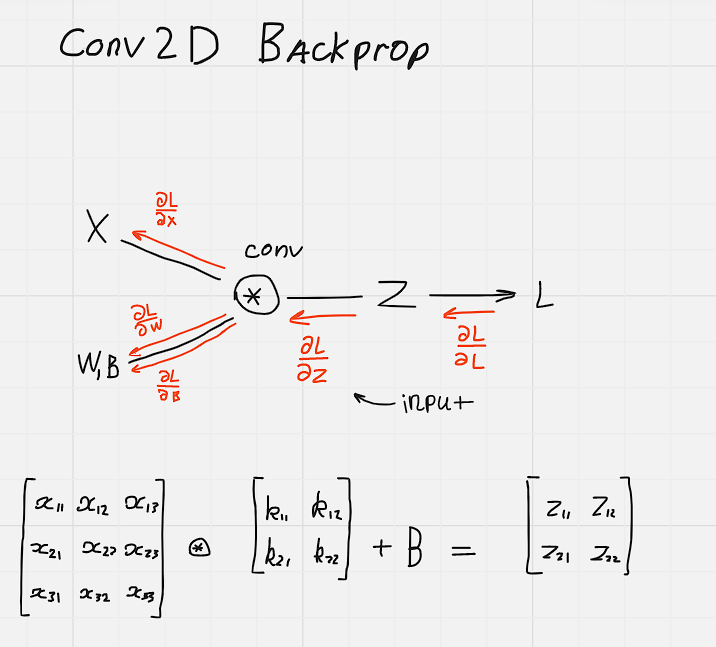

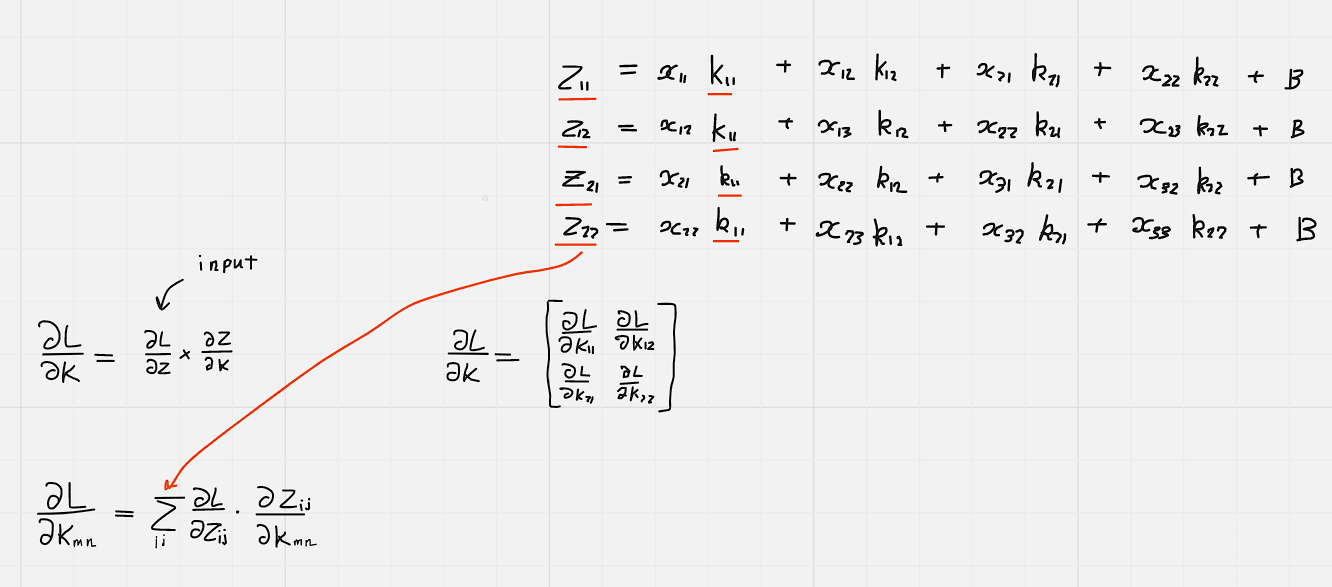

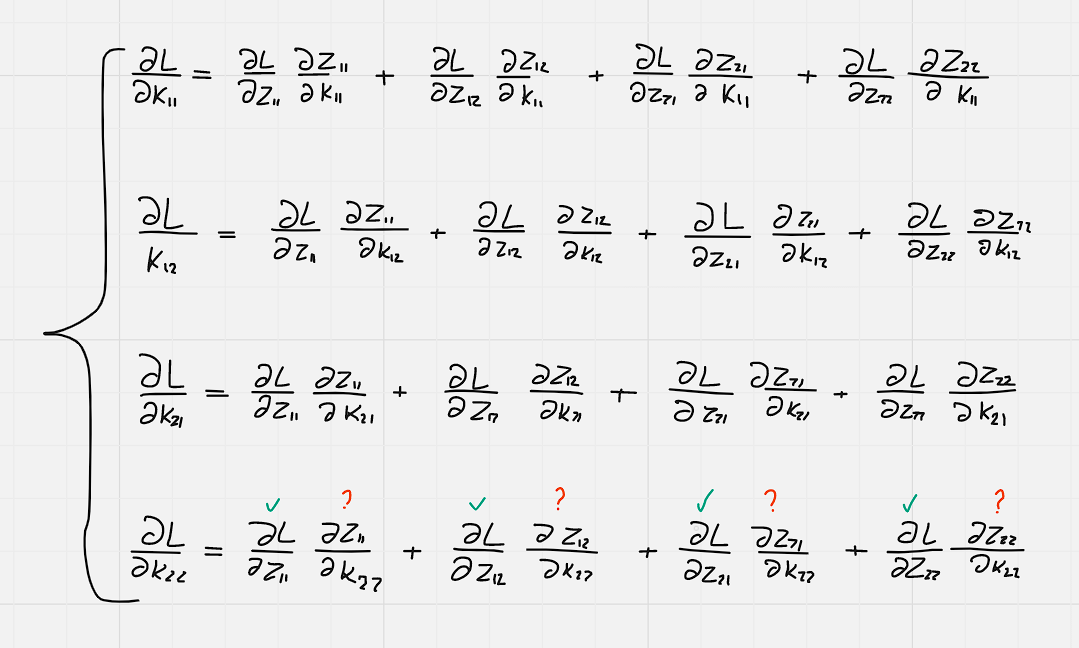

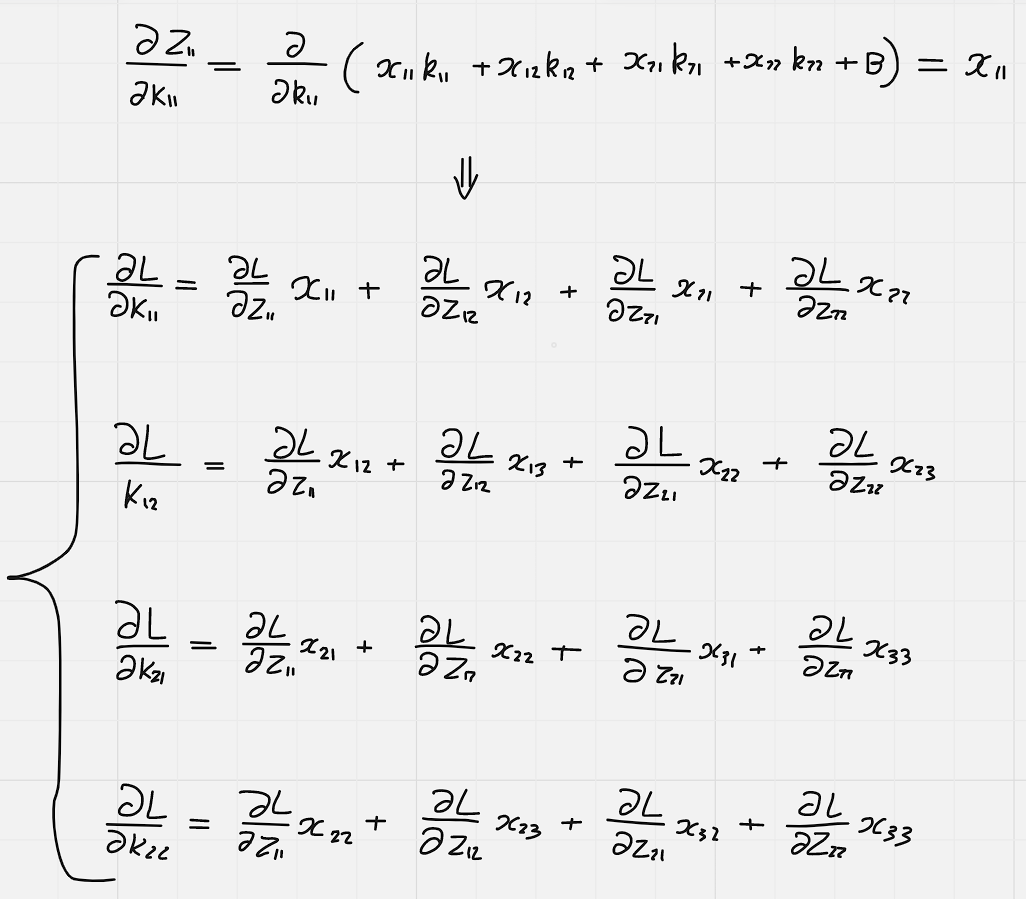

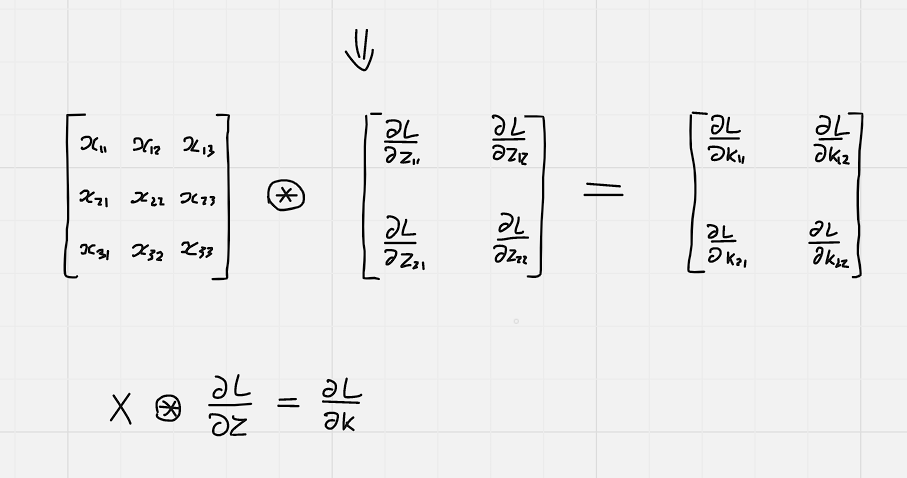

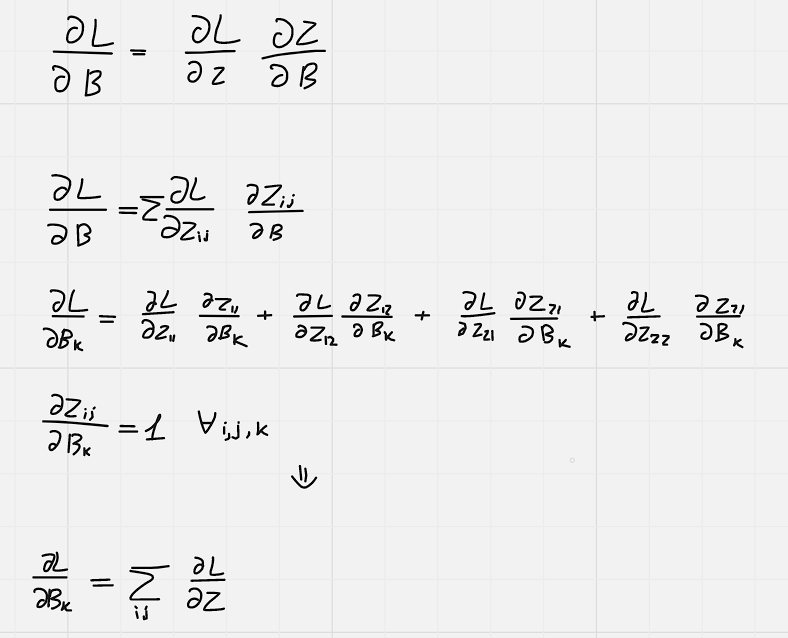

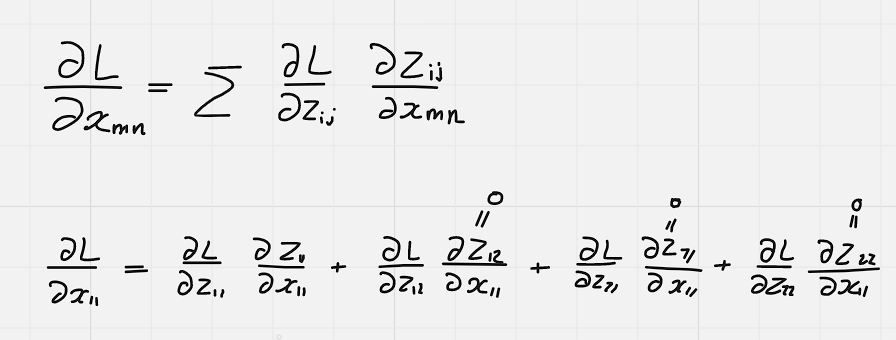

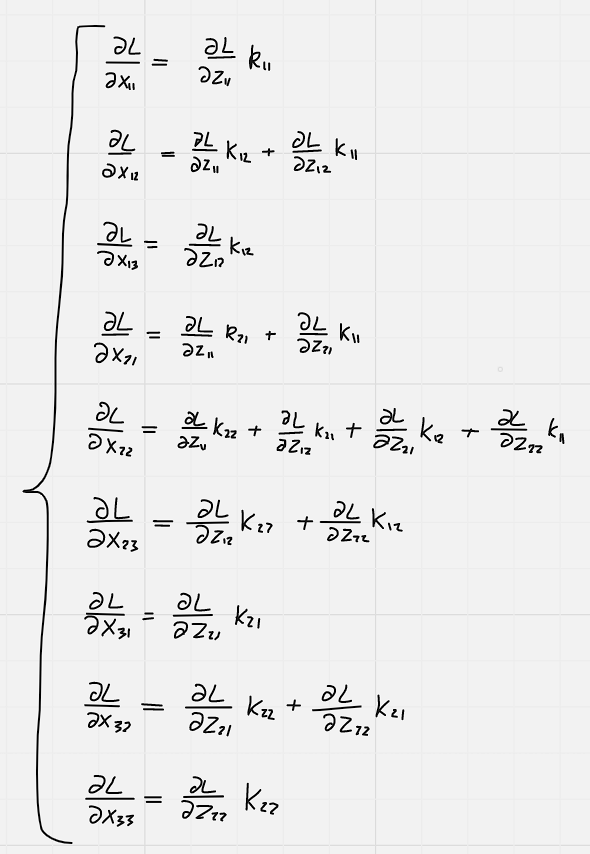

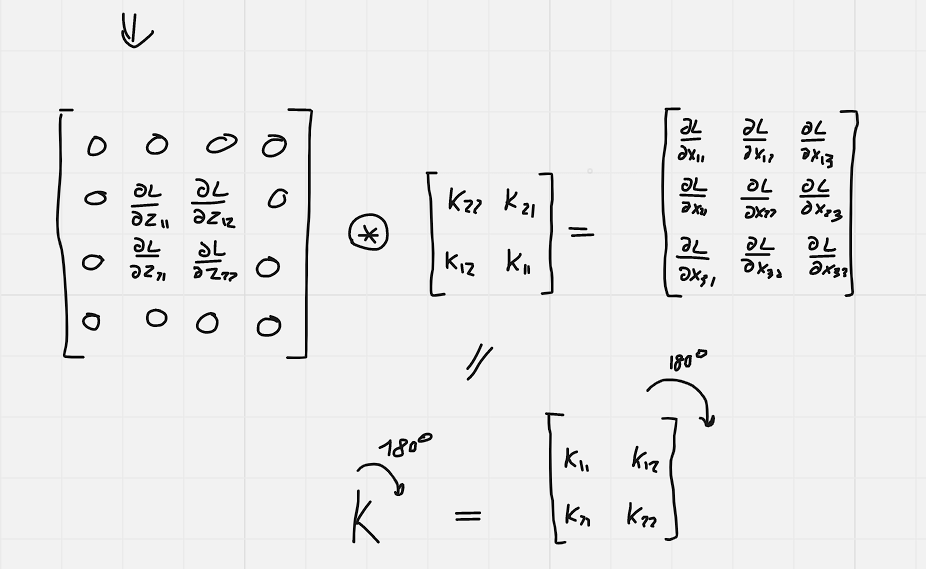

# Conv2DTranspose formulas

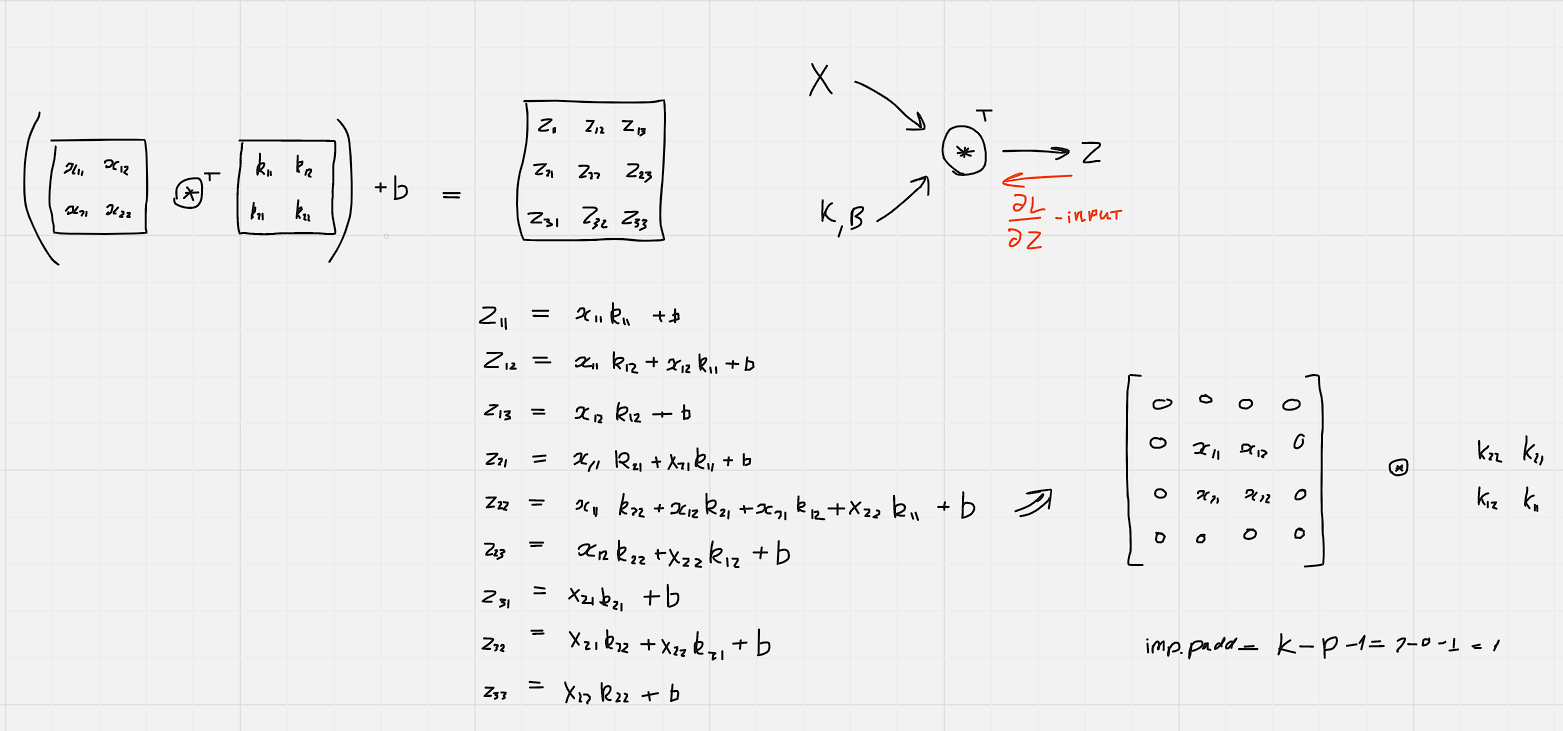

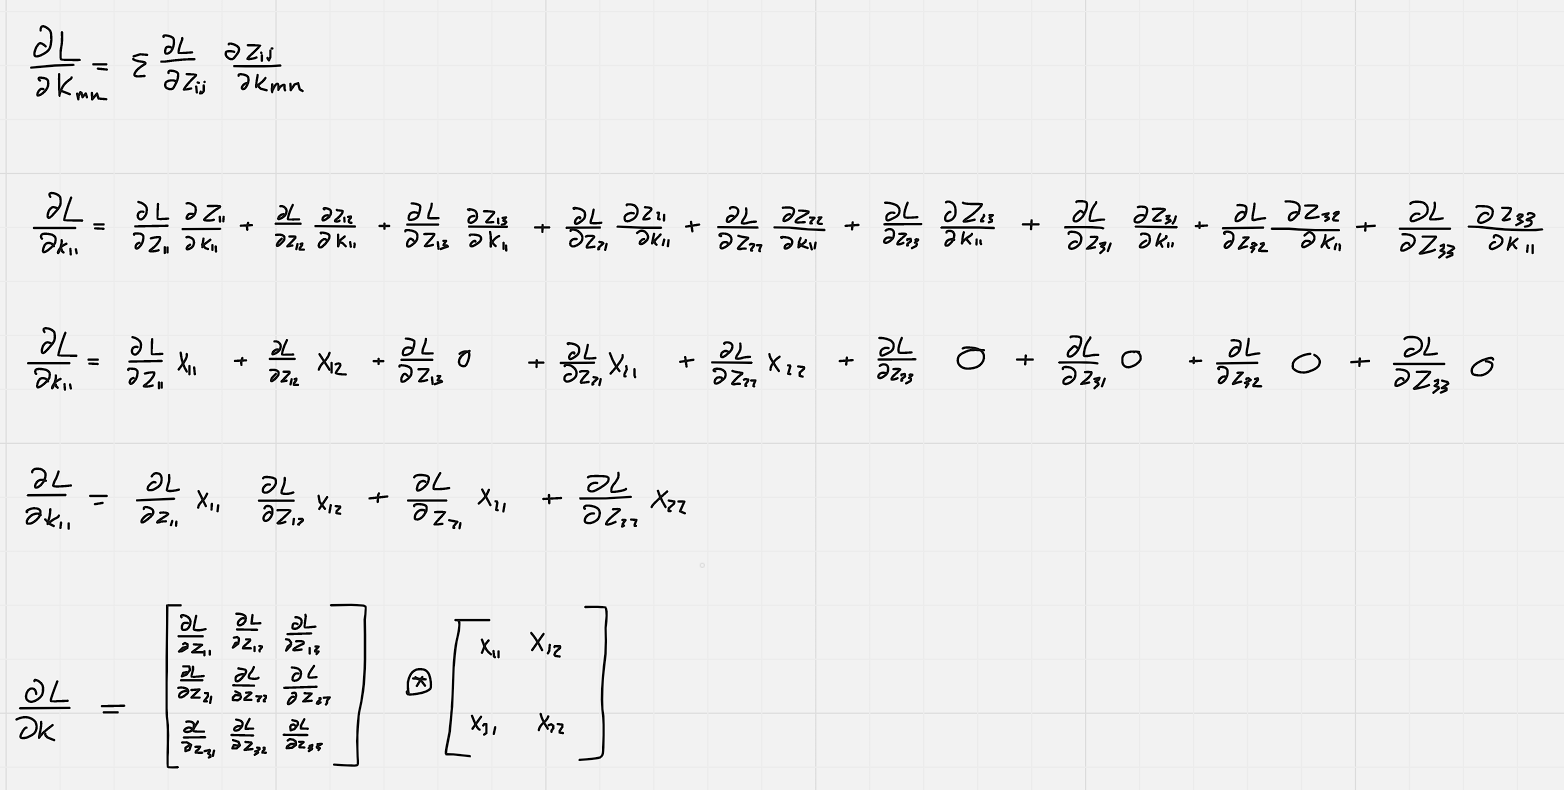

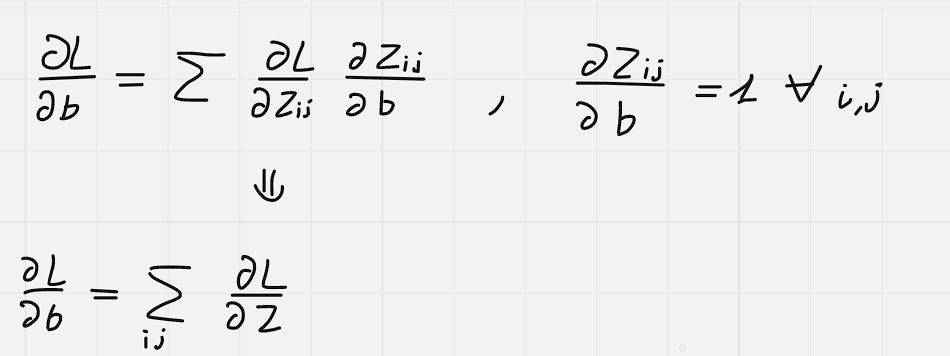

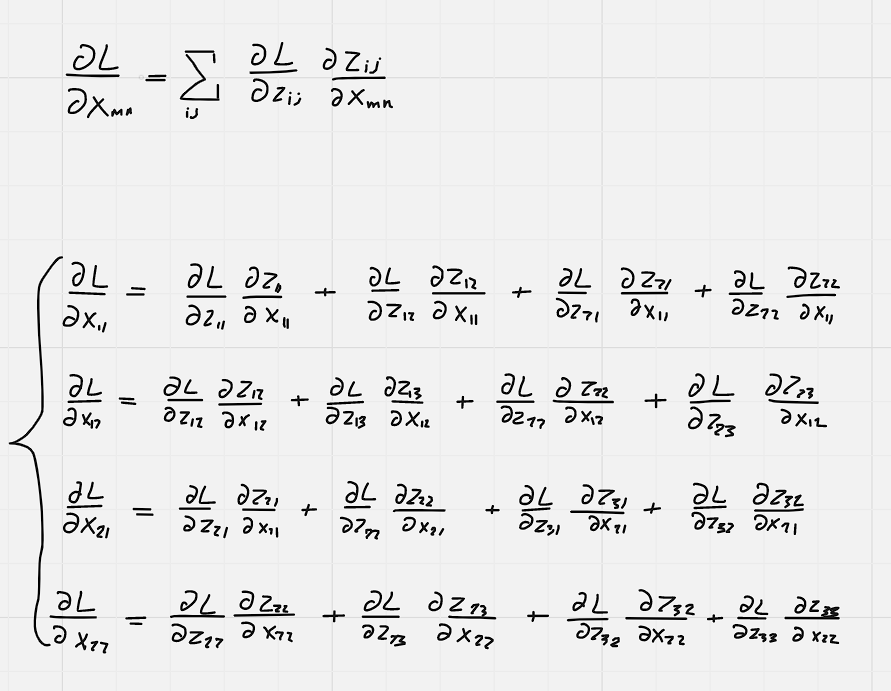

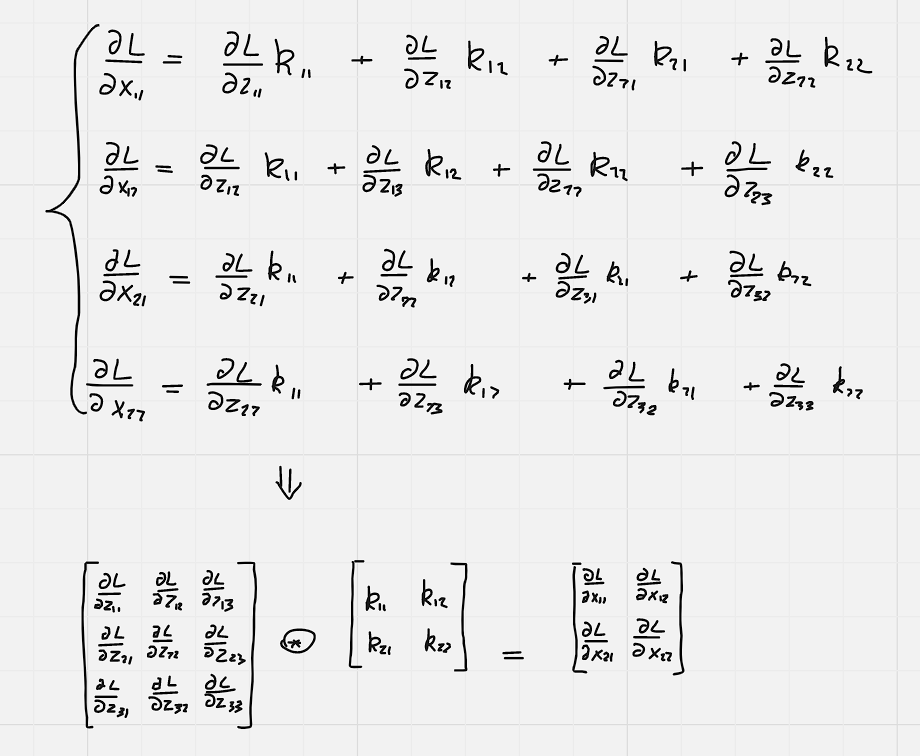